# Purpose

This notebook presents a few visualizations pertaining to the dataset. I use the SP500 as we have been using. I've decided to  merge our two ideas of market events. To refresh our main ideas were, 1.5 the standard deviation $\sigma$ and the other was more qualitative events, like how to predict the Iphone increases or other metrics. My thought process for merging them was simple, we want the data to speak for itself, in the sense that our metric should be data driven and not human dependent. But we also want something that captures the rarity of such events. Therefore, I just adjusted the threshold to be 6 standard deviations away from a daily estimate of the yearly voltaility. I.e. $\frac{\sigma}{\sqrt{252}}$ the number of trading days in a year  

# Changes from Last time

1.) Increased the amount of data I'm pulling to roughly a 10 year period from 2007-01-01 to 2017-10-16.

2.) Providing Visualization of the rare events and  distribution of the volatility

3.) Implemented a quick Deep Learning model in Keras to gauge performance. Hyperparameters have already been tuned to some degree. I present a simple convolutional neural network in keras as a first pass. For more fine tuning, we should migrate to tfslim or raw tensorflow for more control
## Note:
### The main takeaways are in  the section right under "Modeling" and the conclusion. Please read these as they have some key ideas for modeling this particular dataset that I've discovered and had to deal with


In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: Michael Di Amore
"""

%matplotlib inline
import tensorflow as tf
import Query as query
import numpy as np
np.random.seed(12345) # Set seed

import pandas as pd
from sklearn.mixture import GaussianMixture
from hmmlearn.hmm import GMMHMM
from hmmlearn.hmm import GaussianHMM
from imblearn.combine import SMOTEENN 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.decomposition import PCA
from keras.layers import Dense,BatchNormalization,Input,Convolution1D,GRU,Dropout,TimeDistributedDense
from keras.models import Model
import keras
import pdb
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,recall_score,precision_score
import warnings
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 6)

Using TensorFlow backend.


# Load Data 

In [2]:
####
#  Load Data. If you don't want to / can't run the query.
# Basically this is all data from 2007-01-01 to 2017-10-06
load_data = True
if load_data == True:
    print ('Loading Data...')
    df_early = pd.read_csv('Gdelt_events_20070101_20131231.csv')
    df_early = df_early.set_index('sqldate',drop=True).sort_index()
    df_2014_01 = pd.read_csv('Gdelt_events_20140101_20140531.csv')
    df_2014_01  = df_2014_01 .set_index('sqldate',drop=True).sort_index()
    
    df_2014_02 = pd.read_csv('Gdelt_events_20140601_20141231.csv')
    df_2014_02  = df_2014_02 .set_index('sqldate',drop=True).sort_index()
    
    df1 = pd.read_csv('Gdelt_events_20150101_20151231.csv')
    df1 = df1.set_index('sqldate',drop=True).sort_index()
    df2 = pd.read_csv('Gdelt_events_20160101_20171006.csv')
    df2 = df2.set_index('sqldate',drop=True).sort_index()
    gdelt_df = pd.concat([df_early,df_2014_01,df_2014_02,df1,df2])
    
    del df_early,df_2014_01,df_2014_02,df1,df2
    
####
# Set Params
lookback_window = 252
daily_security_vol_target = .15/np.sqrt(252) #.15 is the 10 year SPY volalility found here
#http://performance.morningstar.com/funds/etf/ratings-risk.action?t=SPY&region=usa&culture=en-US
####

proj_id = 'capstone-v0'
start_date = '2007-01-01'
end_date = '2017-10-06'
ticker = '^GSPC'
my_query = query.query_tool(proj_id,start_date,end_date,ticker)
sql_query = """
            SELECT Actor1Name, GoldsteinScale,NumMentions,sourceurl,
            sqldate, avgtone, numarticles, numsources,  
            FROM [gdelt-bq:full.events] 
            WHERE sqldate > 20070101 and sqldate <= 20131231  and 
            Actor1Code like '%BUS%'and
            Actor1Geo_CountryCode like "%US%"
            """
if load_data == False:
    print ('Querying Gdelt...')
    my_query.query_gdelt(sql_query)
    my_query.gdelt_df = my_query.gdelt_df.set_index('sqldate',drop=True).sort_index()
    df = my_query.gdelt_df.copy(True)

#Creating Labels. i.e. if change in spx_return is x standard deviations
security_prices = my_query.query_yahoo()
security_return = np.log(security_prices['Adj Close']).diff() #log Return
security_vol = security_return.rolling(window=lookback_window).std().dropna()
security_vol.name = 'Volatility'
security_return = security_return.loc[security_vol.index] #First entry is NAN because of return
day_over_day_diff = np.abs(security_return.diff())#can subtract because of log returns
event_idx = [daily_security_vol_target * 6 < day_over_day_diff]
event_idx = np.array(event_idx).astype(int).flatten()
event_idx = pd.Series(event_idx,index=day_over_day_diff.index)
print ('Data Loaded')

Loading Data...
Data Loaded


# Visualizations

### Distributions of Target

Lets start by examining the dates of the "market events" and the distributions of volatility

Number of events over time frame 47
Approximate number of years in time frame 9.757936507936508
DatetimeIndex(['2008-03-19', '2008-09-16', '2008-09-17', '2008-09-18',
               '2008-09-22', '2008-09-29', '2008-09-30', '2008-10-01',
               '2008-10-09', '2008-10-10', '2008-10-13', '2008-10-14',
               '2008-10-15', '2008-10-16', '2008-10-21', '2008-10-23',
               '2008-10-28', '2008-10-29', '2008-11-05', '2008-11-07',
               '2008-11-13', '2008-11-14', '2008-11-19', '2008-11-21',
               '2008-12-01', '2008-12-02', '2008-12-05', '2008-12-09',
               '2008-12-16', '2008-12-17', '2009-01-20', '2009-01-21',
               '2009-01-22', '2009-01-29', '2009-02-11', '2009-02-24',
               '2009-03-05', '2009-03-10', '2009-03-11', '2009-03-23',
               '2009-03-24', '2009-04-21', '2010-05-10', '2011-08-08',
               '2011-08-09', '2011-08-10', '2011-08-11'],
              dtype='datetime64[ns]', name='Date', freq=None)


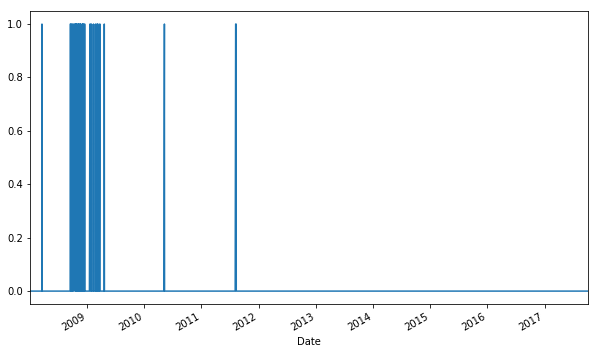

In [3]:
print ('Number of events over time frame {}'.format(event_idx.sum()))
print('Approximate number of years in time frame {}'.format(len(event_idx)/252))
print (event_idx.index[np.where(event_idx==1)])

plt.figure()
event_idx.plot()


As we can see the number of volatility events takes place mostly between 2008-2009 as expected

Now lets take a look at a price chart, this is helpful for us to understand the drift of the security, and maybe if anyone has any insight we could switch gears to predicting returns/prices instead of volatility. However, the literature normally suggest that volatilty is easier to predict. But is still debatable 

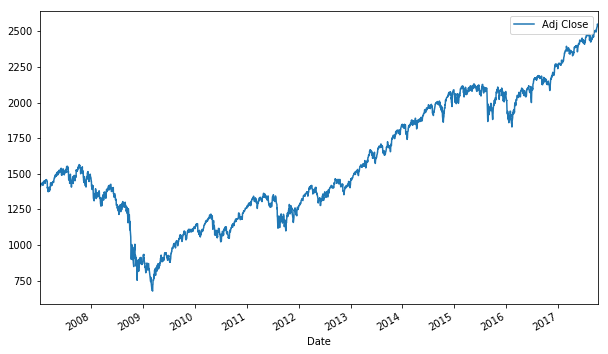

In [4]:
plt.figure()
security_prices['Adj Close'].plot()
plt.legend()

How has the volatility evolved over time? Note this is the 252 day moving average, or a trading year. Notice how volatility  skyrockets during the crisis of 2008-2009 and is now at all significant lows. We can think of market volatility as determing the regime we are currently in, in the market. To make it more concrete think of volatility levels as determining the state from which all market returns are generated

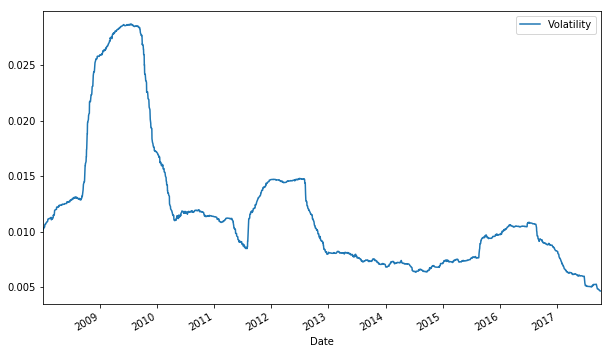

In [5]:
plt.figure()
security_vol.plot()
plt.legend()

What is the distribution of volatility over this period? As you can see the histogram doesn't appear to look like any familiar family of distributions. The kde smoothed estimate looks sort of bimodal with fat tails

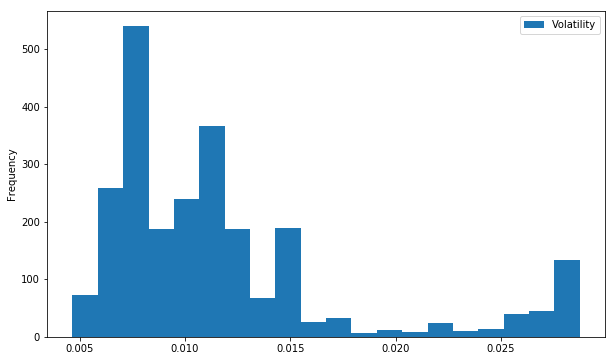

In [6]:
plt.figure()
security_vol.plot.hist(bins=20)
plt.legend()

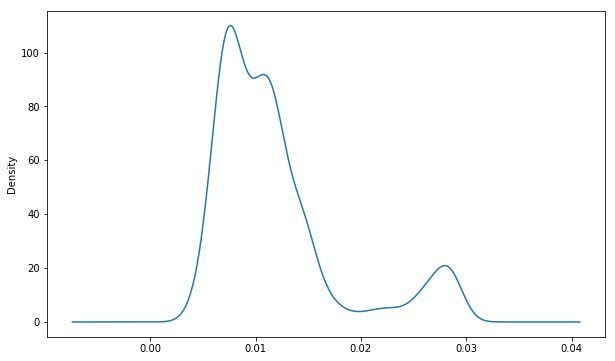

In [7]:
security_vol.plot.kde()

### Distribution of features

First let's collapse our data, i.e. groupby and find the mean. Thereby controlling for some days having more news than other days. This also puts things on daily time scales. 

In [8]:
collapsed = gdelt_df.groupby(by=gdelt_df.index).mean()


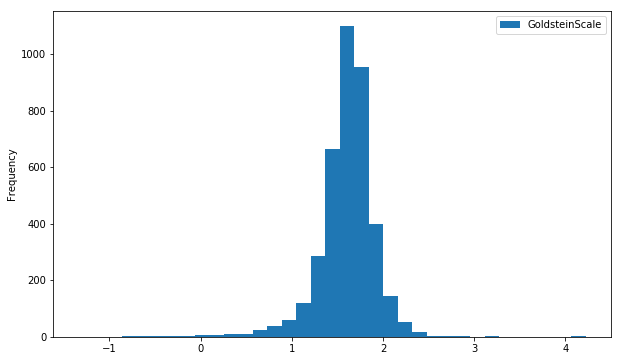

In [9]:
plt.figure()
collapsed['GoldsteinScale'].plot.hist(bins=35)
plt.legend()

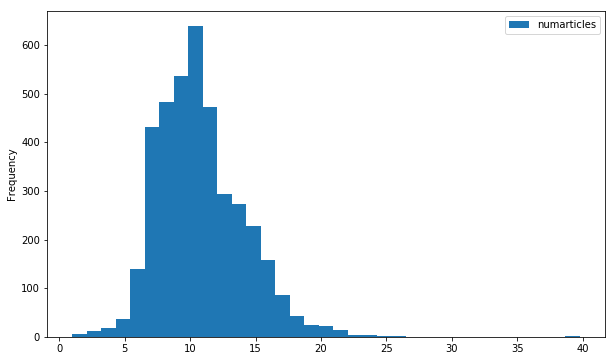

In [10]:
plt.figure()
collapsed['numarticles'].plot.hist(bins=35)
plt.legend()

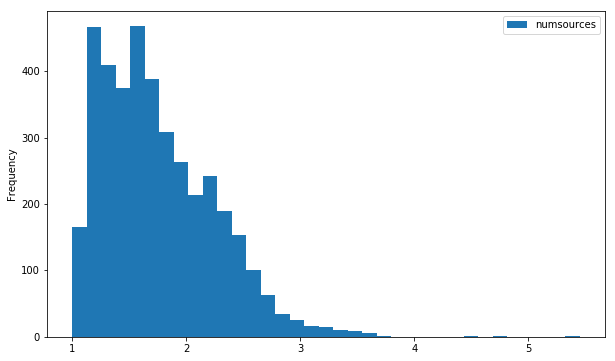

In [11]:
plt.figure()
collapsed['numsources'].plot.hist(bins=35)
plt.legend()

The Goldenstein Scale Distribution appears to be highly peaked with long tails

The Numartciles distribution looks like it is approaching a unimodal gaussian

The numsources distribution looks like it could be  some variant of the exponential 

# Modeling

There are some modeling considerations to take into account after observing the data. The first and most important is that even though this is a time series with time dependancies, most of the market events happen during the earlier part of the data set. As such if we split into train,validation, and test without shuffling we'll end up with no events in the validation and testing set. However, if we do shuffle we throw away the interdependency of the observations. This might be beneficial and something we want to do, or not. It warrants further study. As a first pass I've chosen to shuffle just so we can observe the predictive power of the nerual network

The second is the relatively low amount of data. Neural Networks require a large amount of data most of the time to get any result. How can we overcome our lack of data? Even with 10.5 years worth of data that's only roughly 2000-3000 datapoints. After splitting into three sets were even left with fewer for training and testing. My solution is to generate synthetic data to add ONLY to the training set. And leave the holdout and test sets coming from the original data. I choose to use a Gaussian Mixture to generate synthetic samples as the Goldenstein scale and num articles distributions at least appear to be unimodal.

The third is class imbalance. Given our current definition market events are rare, on the order of 1% of the entire dataset. Even less if we choose a more stringent metric. We'll have to do some sort of oversampling. While generating from the GMM helps in some regard as it will generate more positive than negative examples, we'll also need to perform oversampling via SMOTE. One thing I noticed after experimentation is that I get the best results with a +/- class ratio of about 50% in Y_train. So we should regulate our GMM and SMOTE to have this ratio or whatever ratio we end up choosing. To do this see the code below.

In [21]:
#Collapse numerical data into x,y pairs by taking means
collapsed = gdelt_df.groupby(by=gdelt_df.index).mean()
collapsed_shifted = collapsed.shift(1)
collapsed_shifted.index = pd.to_datetime(collapsed_shifted.index,format='%Y%m%d')
collapsed_shifted = collapsed_shifted.loc[security_vol.index].dropna()
print ('Creating train test split...')
X_train,X_test,Y_train,Y_test = train_test_split(collapsed_shifted,event_idx,stratify=None,test_size=.60,shuffle=True)
X_train,X_val,Y_train,Y_val = train_test_split(X_train,Y_train,test_size=.60,stratify=None,shuffle=True)

#Creating Copies of Data Frames these will be useful later
Y_train_df = X_train.copy(True)
Y_val_df = Y_val.copy(True)

#Performing Scaling
print ('Scaling the data...')
X_train = np.array(X_train).reshape(-1,X_train.shape[1])
ss = StandardScaler()
ss = ss.fit(X_train)
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)
X_val = ss.transform(X_val)
pca = PCA(whiten=True)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
X_val = pca.transform(X_val)

print ('Performing Oversampling/Undersampling...')
s = SMOTEENN()
X_train,Y_train= s.fit_sample(X_train,Y_train)


#Important!:
#Gaussian Mixture will generate a random amount of Y's from some mixture to make sure we have the proportion we want
#We have to run a loop to generate many samples
#Want to target 50% as the proportion of 1's/0's with some leeway
desired_prop = .50
num_hallucinated_samples = 30000
want = desired_prop*(num_hallucinated_samples + Y_train.sum())
lb = want - .10*num_hallucinated_samples
ub = want + .10*num_hallucinated_samples
total_sum = np.inf

print ('Creating synthetic examples...')
#This creates different gaussian mixtures until we get the desired proportion
while (total_sum < lb) or (total_sum > ub):
    X_synth,Y_synth = GaussianMixture(n_components=2,max_iter=1000,covariance_type='diag').fit(X_train,Y_train).sample(num_hallucinated_samples)
    total_sum = Y_synth.sum() + Y_train.sum()
#Combine X_synth, Y_synth with X_train Y_train
X_train = np.concatenate((X_synth,X_train))
Y_train = np.concatenate((Y_synth,Y_train))

X_train = X_train.reshape(-1,X_train.shape[1],1)
X_test = X_test.reshape(-1,X_test.shape[1],1)
X_val = X_val.reshape(-1,X_val.shape[1],1)
print ('Done!')

Creating train test split...
Scaling the data...
Performing Oversampling/Undersampling...
Creating synthetic examples...
Done!


In [22]:
print(Y_train.sum()/len(Y_train))

0.428878818505


In [23]:
from keras.regularizers import l1l2
from keras.constraints import maxnorm
from keras.layers import MaxoutDense
from keras.layers import Flatten
from keras.layers import MaxPooling1D


def simple_keras_model(original):
    original_input = Input(shape=(original.shape[1],1),name='orig')
    layer1 =  Convolution1D(512, 5, border_mode='same',activation='relu',init='he_normal',W_constraint=maxnorm(0.5))(original_input)
    layer1 = BatchNormalization()(layer1)
    layer1 = MaxPooling1D()(layer1)
    layer1 = Dropout(.55)(layer1)
    layer2 = Convolution1D(512,5,border_mode='same',activation='relu',init='he_normal',W_constraint=maxnorm(0.5))(layer1)
    layer2 = BatchNormalization()(layer2)
    layer2 = MaxPooling1D()(layer2)
    layer2 = Dropout(.55)(layer2)
    layer3 = Convolution1D(256,3,border_mode='same',activation='relu',init='he_normal',W_constraint=maxnorm(0.5))(layer2)
    layer3 = BatchNormalization()(layer3)
    layer3 = Dropout(.55)(layer3)
    layer4 = Convolution1D(128,3,border_mode='same',activation='relu',init='he_normal',W_constraint=maxnorm(0.5))(layer3)
    layer4 = BatchNormalization()(layer4)
    layer4 = Dropout(.55)(layer4)
    
    
#     layer5 = Convolution1D(32,3,border_mode='same',activation='relu',init='he_normal')(layer4)
#     layer5 = BatchNormalization()(layer5)
#     layer5 = Dropout(.35)(layer5)
    

#     layer6 = Convolution1D(32,3,border_mode='same',activation='relu',init='he_normal')(layer5)
#     layer6 = BatchNormalization()(layer6)
#     layer6 = Dropout(.35)(layer6)
    
    
#     layer7 = Convolution1D(32,3,border_mode='same',activation='relu',init='he_normal')(layer6)
#     layer7 = BatchNormalization()(layer7)
#     layer7 = Dropout(.35)(layer7)
    
    
#     layer8 = Convolution1D(32,3,border_mode='same',activation='relu',init='he_normal')(layer7)
#     layer8 = BatchNormalization()(layer8)
#     layer8 = Dropout(.35)(layer8)
    
#     flattened = Flatten()(layer8)
#     layer9 = MaxoutDense(1024,init='he_normal')(flattened)
#     layer9 = BatchNormalization()(layer9)
#     layer9 = Dropout(.35)(layer9)
#     layer10 =MaxoutDense(512,init='he_normal')(layer9)
#     layer10 = BatchNormalization()(layer10)
#     layer10 = Dropout(.35)(layer10)
#     layer11 = MaxoutDense(128,init='he_normal')(layer10)
#     layer11 = BatchNormalization()(layer11)
#     layer11 = Dropout(.35)(layer11)
    
    flattened = Flatten()(layer4)
    output = Dense(1,activation='sigmoid')(flattened)
    

    my_model = Model([original_input], output=output)
    optimizer_adam = keras.optimizers.adam(0.001) 
    my_model.compile(loss='binary_crossentropy', optimizer=optimizer_adam, metrics=['accuracy'])

    return(my_model)

In [24]:
my_model = simple_keras_model(X_train)
my_model.fit(X_train,Y_train,nb_epoch=75,batch_size=128)

Epoch 1/75
30673/30673 [==============================] - 8s - loss: 0.1006 - acc: 0.9691     
Epoch 2/75
30673/30673 [==============================] - 4s - loss: 0.0647 - acc: 0.9800     
Epoch 3/75
30673/30673 [==============================] - 4s - loss: 0.0575 - acc: 0.9830     
Epoch 4/75
30673/30673 [==============================] - 4s - loss: 0.0561 - acc: 0.9825     
Epoch 5/75
30673/30673 [==============================] - 4s - loss: 0.0509 - acc: 0.9844     
Epoch 6/75
30673/30673 [==============================] - 4s - loss: 0.0528 - acc: 0.9834     
Epoch 7/75
30673/30673 [==============================] - 4s - loss: 0.0504 - acc: 0.9839     
Epoch 8/75
30673/30673 [==============================] - 4s - loss: 0.0504 - acc: 0.9841     
Epoch 9/75
30673/30673 [==============================] - 4s - loss: 0.0497 - acc: 0.9844     
Epoch 10/75
30673/30673 [==============================] - 4s - loss: 0.0494 - acc: 0.9844     
Epoch 11/75
30673/30673 [========================

In [25]:
def proba_to_label(pred,threshold):
    ones = np.array([pred > threshold])
    ones = ones.flatten()
    return (ones)

In [68]:
def plot_figs(Y,label):
    plt.figure()
    security_vol.loc[Y.index].plot()
    position = Y.index[np.where(Y==1)]
    for xc in position:
        plt.axvline(x=xc, color='r', linestyle='solid',linewidth=.55)
    plt.legend()
    plt.ylabel('Volatility')
    plt.xlabel('Time')

    plt.figure()
    security_vol.loc[Y.index].plot()
    label_position = Y.index[np.where(label==1)]
    for xc in label_position:
        plt.axvline(x=xc, color='b', linestyle='solid',linewidth=.55)

    plt.figure()
    security_vol.loc[Y.index].plot()
    matching_position = Y.index[np.where(label==1) and np.where(Y==1)]
    for xc in matching_position:
        plt.axvline(x=xc, color='g', linestyle='solid',linewidth=.55)


    plt.legend()
    plt.ylabel('Volatility')
    plt.xlabel('Time')

In [69]:
proba_cut_off = .50 #can adjust this to make model more or less stringent

pred = my_model.predict(X_val)
labels = proba_to_label(pred,proba_cut_off) 
labels = labels.astype(int)
acc = accuracy_score(Y_val,labels)
f1 = f1_score(Y_val,labels)
roc = roc_auc_score(Y_val,labels)
prec = precision_score(Y_val,labels)
recall= recall_score(Y_val,labels)

print (' Accuracy: {}'.format(acc))
print (' F1: {}'.format(f1))
print (' RoC: {}'.format(roc))
print (' Precision: {}'.format(prec))
print (' Recall: {}'.format(recall))



 Accuracy: 0.8661016949152542
 F1: 0.15053763440860213
 RoC: 0.6577743902439025
 Precision: 0.09090909090909091
 Recall: 0.4375


In [70]:
print(np.where(labels==1))
print(np.where(Y_val==1))

(array([  8,  16,  22,  51,  53,  57,  63,  83, 104, 128, 130, 131, 132,
       136, 153, 155, 156, 165, 167, 171, 185, 205, 220, 226, 228, 236,
       238, 247, 257, 258, 264, 266, 268, 269, 292, 295, 305, 324, 338,
       357, 361, 365, 366, 369, 387, 405, 410, 416, 436, 439, 447, 450,
       452, 454, 456, 462, 465, 469, 472, 475, 479, 484, 495, 497, 502,
       508, 511, 515, 528, 530, 534, 535, 537, 545, 548, 580, 582]),)
(array([  7,  16, 153, 221, 254, 293, 307, 310, 319, 400, 447, 452, 469,
       484, 511, 543]),)


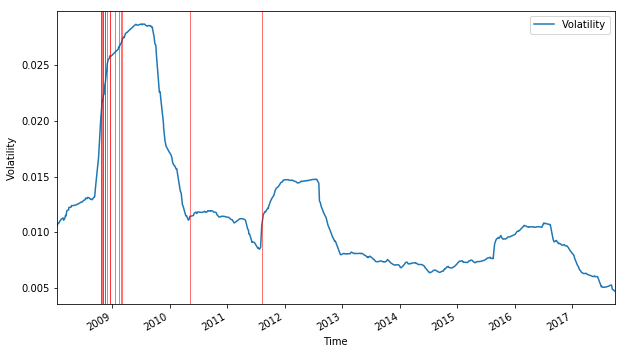

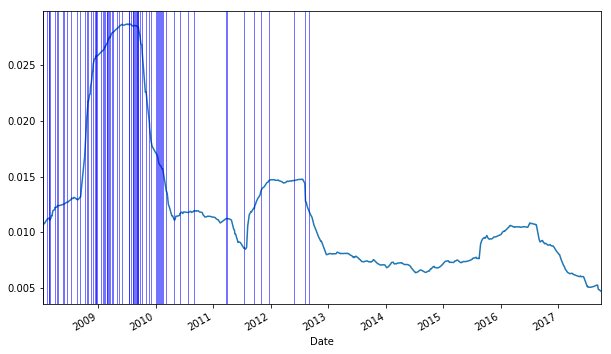

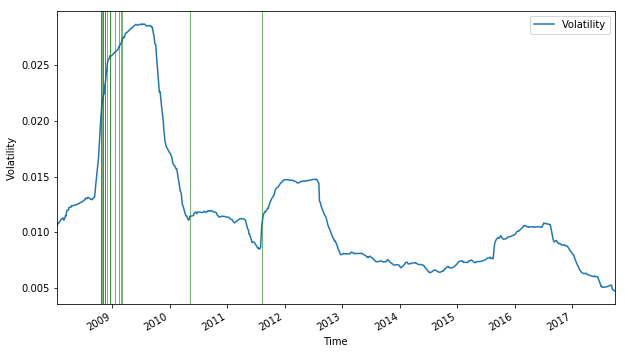

In [71]:
plot_figs(Y_val,labels)


In the above the first plot, vertical lines represent events in the validation set. 

In the second plot, vertical lines represent predicted events

In the third plot, vertical lines represent events both in the predicted and validation set

While the predicted set certainly overstates the number of events, we can see that it accuractely predicts a number of them

In [72]:
pred2 = my_model.predict(X_test)
labels2 = proba_to_label(pred2,0.5)
labels2 = labels2.astype(int)
acc = accuracy_score(Y_test,labels2)
f1 = f1_score(Y_test,labels2)
roc = roc_auc_score(Y_test,labels2)
prec = precision_score(Y_test,labels2)
recall= recall_score(Y_test,labels2)

print (' Accuracy: {}'.format(acc))
print (' F1: {}'.format(f1))
print (' RoC: {}'.format(roc))
print (' Precision: {}'.format(prec))
print (' Recall: {}'.format(recall))


 Accuracy: 0.8875338753387534
 F1: 0.1075268817204301
 RoC: 0.6848306332842417
 Precision: 0.06060606060606061
 Recall: 0.47619047619047616


In [73]:
z2 = Y_test.index[np.where(labels2==1)]
z2.sort_values()

DatetimeIndex(['2008-01-11', '2008-01-17', '2008-02-05', '2008-02-06',
               '2008-02-07', '2008-02-26', '2008-02-29', '2008-03-07',
               '2008-04-09', '2008-04-14',
               ...
               '2012-07-09', '2012-07-23', '2012-07-30', '2012-09-17',
               '2012-09-25', '2012-09-26', '2012-10-08', '2012-10-15',
               '2012-10-16', '2012-10-19'],
              dtype='datetime64[ns]', name='Date', length=165, freq=None)

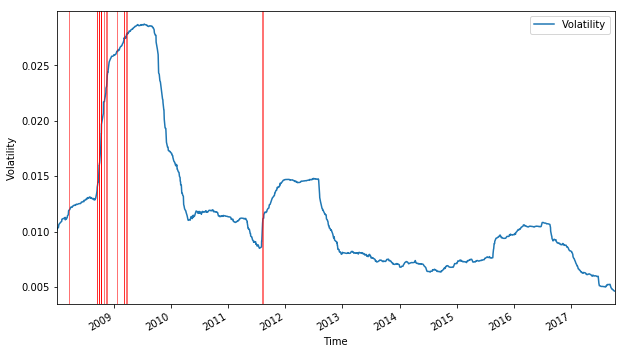

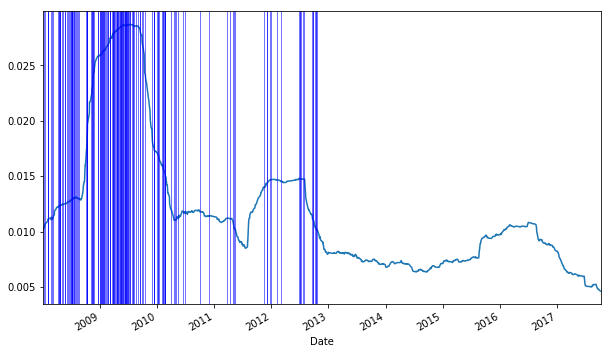

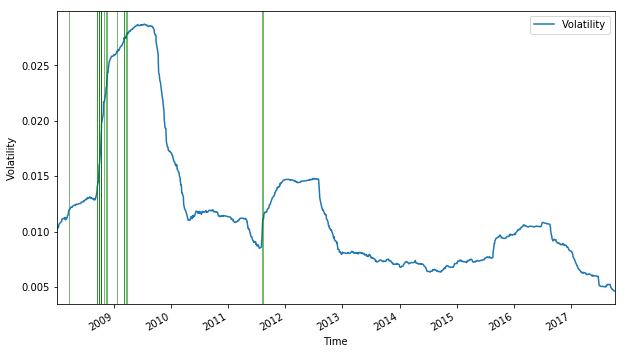

In [75]:
plot_figs(Y_test,labels2)

While the test set too often predicts a market event, it is able to predict the high volatility period and stays "on throughout the whole period until it's downfall. But the fact remains that this version has many false positives.

## Conclusion and Next Steps

1.) Although deep learning is able to get us and we  are able to predict market events and have high accuracy, we predict them far too often. 

2.) However, it's not all bad. We can see from the results on the validation and test set that our prediction predict a market event before they happen and stay "on" for some time after they happen. One key point to keep in mind is that we even shifted our data, so we're using the day before's news to predict the next day. If we relaxed this condition it might make a difference. 

3.) To restate the modeling framework, we shuffled our data. This removes the interdependencies on day over day data. But it also allows for some future information to seep in. By having different dates in our samples. I have no intuition of which one prevails (the "independence" or the "leakage") so we'll have to try a model without shuffle. Which means we'd need to find a metric that puts some events in our validation and testing sets or we can't run measures like F1/ROC/Precision/Recall

4.) Next steps: 
     - Explore with a non shuffled dataset
     - Try new Neural Network architectures. Particularly if we don't shuffle the data we might make use of RNN's/GRU
     - More hyperparameter tuning, though I did quite a bit  of this
     - Find a way to make the synthetic generation more robust, as it is now it generates samples somewhat wildly. This might just be a feature of the GMM. Perhaps we could use an HMM
     - Try out AAPL / other stocks of interest  (would require retuning hyperparameters most likely)